This notebook present the steps to generate merged catalog files. The reason that we need to generate such files is that:

1. Bliss needs input parameters that contains psf, fluxes, location, source type, galaxy related parameters, but the truth catalog in DC2 does not provide galaxy parameters or psf
2. To get those parameter, we need to use CosmoDC2 dataset and truth-match table, where the galaxy parameters and psf are stored.
3. To save the time for multiple merging when loading the data, we store the merged dataset into corresponding merged_catalog_{}.pkl files

### Load Catalog

Use [GCRCatalogs](https://data.lsstdesc.org/doc/install_gcr) package to load the dc2 truth catalog and CosomoDC2.




In [1]:
import pickle
import GCRCatalogs
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

In [2]:
output_dir = Path("./generate_catalog_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
truth_catalog_pickle_file = output_dir / "truth_catalog.pkl"
GCRCatalogs.set_root_dir("/nfs/turbo/lsa-regier/lsstdesc-public/dc2")
if truth_catalog_pickle_file.exists():
    with open(truth_catalog_pickle_file, "rb") as inputp: 
        truth_cat_data = pickle.load(inputp)
else:   
    truth_cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_truth") 
    truth_cat_data = truth_cat.get_quantities([
        "id", "match_objectId", "cosmodc2_id", "ra", "dec", "truth_type", 
        "flux_g", "flux_i", "flux_r", "flux_u", "flux_y", "flux_z",
        "redshifts",
    ])
    with open(truth_catalog_pickle_file, "wb") as outp:
        pickle.dump(truth_cat_data, outp, pickle.HIGHEST_PROTOCOL)

truth_cat_df = pd.DataFrame(truth_cat_data)

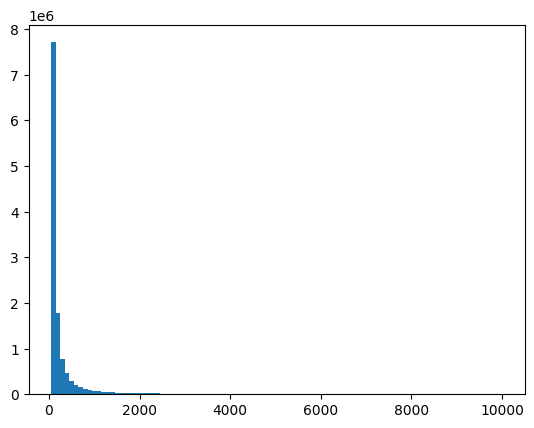

In [4]:
plt.hist(truth_cat_data["flux_r"], np.linspace(50, 10000, num=100))
plt.show()

In [5]:
galaxy_params_pickle_file = output_dir / "galaxy_params.pkl"
if galaxy_params_pickle_file.exists():
    with open(galaxy_params_pickle_file, "rb") as inputp: 
        galaxy_params_data = pickle.load(inputp)
else:
    galaxy_params = GCRCatalogs.load_catalog("desc_cosmodc2", {
        "catalog_root_dir": "/nfs/turbo/lsa-regier/lsstdesc-public/dc2/cosmoDC2",
    })
    galaxy_params_data = galaxy_params.get_quantities([
        "galaxy_id",
        "shear_1", "shear_2",
        "ellipticity_1_true", "ellipticity_2_true",
    ])
    with open(galaxy_params_pickle_file, "wb") as outp:
        pickle.dump(galaxy_params_data, outp, pickle.HIGHEST_PROTOCOL)

galaxy_params_df = pd.DataFrame(galaxy_params_data)

In [6]:
print(len(galaxy_params_df))

337954678


In [7]:
print(np.isnan(galaxy_params_df["shear_1"].values).sum() / len(galaxy_params_df))

0.0


In [8]:
galaxy_params_df["shear_1"].describe()

count    3.379547e+08
mean    -2.685346e-03
std      1.843072e-02
min     -1.842399e-01
25%     -1.317084e-02
50%     -2.250347e-03
75%      7.776476e-03
max      1.913079e-01
Name: shear_1, dtype: float64

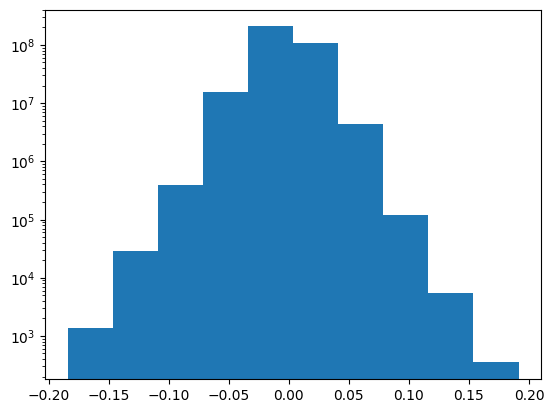

In [9]:
plt.hist(galaxy_params_df["shear_1"], log=True)
plt.show()

In [10]:
print(np.isnan(galaxy_params_df["shear_2"].values).sum() / len(galaxy_params_df))

0.0


In [11]:
galaxy_params_df["shear_2"].describe()

count    3.379547e+08
mean     1.107697e-03
std      1.799174e-02
min     -1.952726e-01
25%     -9.009311e-03
50%      8.590200e-04
75%      1.115994e-02
max      1.886922e-01
Name: shear_2, dtype: float64

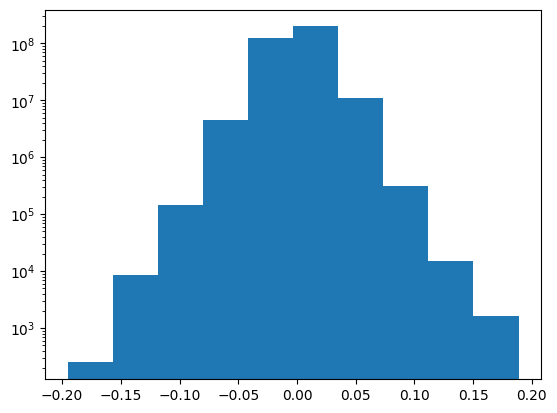

In [12]:
plt.hist(galaxy_params_df["shear_2"], log=True)
plt.show()

In [13]:
print(np.isnan(galaxy_params_df["ellipticity_1_true"].values).sum() / len(galaxy_params_df))

0.0


In [14]:
galaxy_params_df["ellipticity_1_true"].describe()

count    3.379547e+08
mean    -6.839962e-06
std      1.571465e-01
min     -9.428603e-01
25%     -3.821195e-02
50%     -6.784621e-07
75%      3.820050e-02
max      9.477478e-01
Name: ellipticity_1_true, dtype: float64

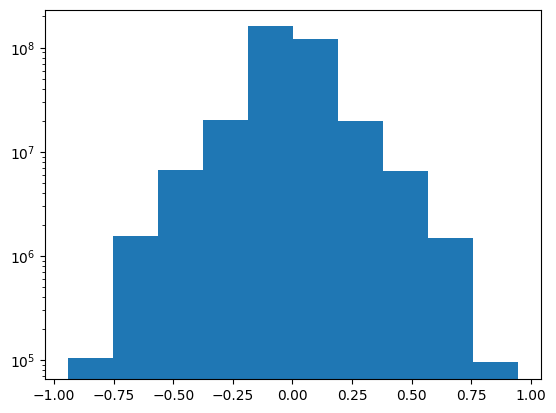

In [15]:
plt.hist(galaxy_params_df["ellipticity_1_true"], log=True)
plt.show()

In [16]:
print(np.isnan(galaxy_params_df["ellipticity_2_true"].values).sum() / len(galaxy_params_df))

0.0


In [17]:
galaxy_params_df["ellipticity_2_true"].describe()

count    3.379547e+08
mean     1.991261e-06
std      1.571864e-01
min     -9.438543e-01
25%     -3.821588e-02
50%     -8.432595e-08
75%      3.821193e-02
max      9.474824e-01
Name: ellipticity_2_true, dtype: float64

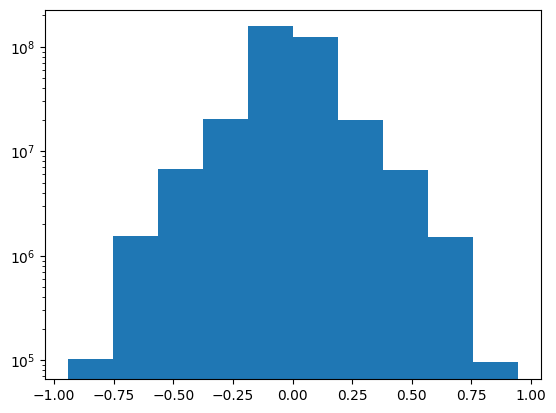

In [18]:
plt.hist(galaxy_params_df["ellipticity_2_true"], log=True)
plt.show()

In [19]:
psf_params_pickle_file = output_dir / "psf_params.pkl"
if psf_params_pickle_file.exists():
    with open(psf_params_pickle_file, "rb") as inputp: 
        psf_params_data = pickle.load(inputp)
else:
    psf_params = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    psf_params_data = psf_params.get_quantities([
        "objectId",
        "blendedness",
        "IxxPSF_pixel_g", "IxxPSF_pixel_z", 
        "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_u", 
        "IxxPSF_pixel_y", "IyyPSF_pixel_g", "IyyPSF_pixel_z", 
        "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_u", 
        "IyyPSF_pixel_y", "IxyPSF_pixel_g", "IxyPSF_pixel_z", 
        "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_u", 
        "IxyPSF_pixel_y", "psf_fwhm_g", "psf_fwhm_z", "psf_fwhm_r",
        "psf_fwhm_i", "psf_fwhm_u", "psf_fwhm_y"
    ])
    with open(psf_params_pickle_file, "wb") as outp:
        pickle.dump(psf_params_data, outp, pickle.HIGHEST_PROTOCOL)

psf_params_df = pd.DataFrame(psf_params_data)

### Merge Catalog 

In [20]:
merged_catalog_pikle_file = output_dir / "merged_catalog.pkl"

truth_galaxy_df = truth_cat_df.merge(
    galaxy_params_df, 
    left_on="cosmodc2_id", 
    right_on="galaxy_id", 
    how="left" 
)
cosmodc2_mask = ~(np.isnan(truth_galaxy_df["ellipticity_1_true"].values))
truth_galaxy_df["cosmodc2_mask"] = cosmodc2_mask
truth_galaxy_psf_df = truth_galaxy_df.merge(
    psf_params_df, 
    left_on="match_objectId", 
    right_on="objectId", 
    how="left" 
)

In [21]:
print(len(truth_cat_df))
print(len(galaxy_params_df))
print(len(psf_params_df))
print(len(truth_galaxy_psf_df))

47003941
337954678
11116206
47003941


In [22]:
for k, v in truth_galaxy_psf_df.items():
    print(f"{k} has {np.isnan(v.values).sum()} nans")

id has 0 nans
flux_i has 0 nans
dec has 0 nans
cosmodc2_id has 0 nans
ra has 0 nans
flux_y has 0 nans
flux_r has 0 nans
flux_g has 0 nans
truth_type has 0 nans
flux_u has 0 nans
match_objectId has 0 nans
flux_z has 0 nans
shear_1 has 3595434 nans
ellipticity_1_true has 3595434 nans
ellipticity_2_true has 3595434 nans
shear_2 has 3595434 nans
galaxy_id has 3595434 nans
cosmodc2_mask has 0 nans
IxxPSF_pixel_y has 35961255 nans
IyyPSF_pixel_y has 35961255 nans
IxyPSF_pixel_i has 35961190 nans
IxyPSF_pixel_u has 35961247 nans
IxyPSF_pixel_g has 35961183 nans
IxxPSF_pixel_r has 35961172 nans
IxyPSF_pixel_z has 35961221 nans
psf_fwhm_u has 35961247 nans
psf_fwhm_y has 35961255 nans
IxxPSF_pixel_g has 35961183 nans
IyyPSF_pixel_u has 35961247 nans
blendedness has 36788474 nans
IyyPSF_pixel_i has 35961190 nans
IxxPSF_pixel_i has 35961190 nans
psf_fwhm_g has 35961183 nans
IyyPSF_pixel_g has 35961183 nans
psf_fwhm_i has 35961190 nans
psf_fwhm_r has 35961172 nans
objectId has 35961167 nans
psf_fw

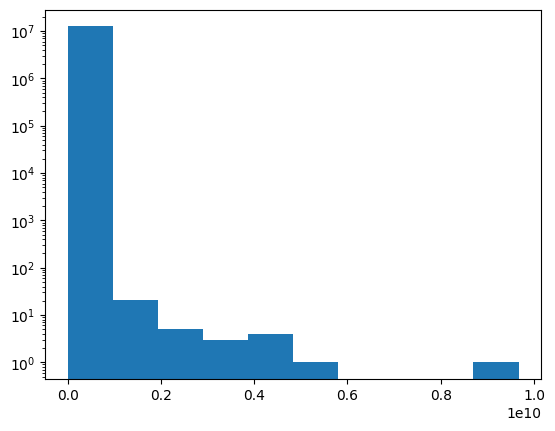

In [23]:
# filter the object by flux
flux_min = 50
truth_galaxy_psf_df = truth_galaxy_psf_df.loc[truth_galaxy_psf_df["flux_r"] > flux_min]
plt.hist(truth_galaxy_psf_df["flux_r"], log=True)
plt.show()

In [24]:
for k, v in truth_galaxy_psf_df.items():
    print(f"{k} has {np.isnan(v.values).sum()} nans")

id has 0 nans
flux_i has 0 nans
dec has 0 nans
cosmodc2_id has 0 nans
ra has 0 nans
flux_y has 0 nans
flux_r has 0 nans
flux_g has 0 nans
truth_type has 0 nans
flux_u has 0 nans
match_objectId has 0 nans
flux_z has 0 nans
shear_1 has 1043618 nans
ellipticity_1_true has 1043618 nans
ellipticity_2_true has 1043618 nans
shear_2 has 1043618 nans
galaxy_id has 1043618 nans
cosmodc2_mask has 0 nans
IxxPSF_pixel_y has 3048330 nans
IyyPSF_pixel_y has 3048330 nans
IxyPSF_pixel_i has 3048262 nans
IxyPSF_pixel_u has 3048313 nans
IxyPSF_pixel_g has 3048264 nans
IxxPSF_pixel_r has 3048256 nans
IxyPSF_pixel_z has 3048295 nans
psf_fwhm_u has 3048313 nans
psf_fwhm_y has 3048330 nans
IxxPSF_pixel_g has 3048264 nans
IyyPSF_pixel_u has 3048313 nans
blendedness has 3452525 nans
IyyPSF_pixel_i has 3048262 nans
IxxPSF_pixel_i has 3048262 nans
psf_fwhm_g has 3048264 nans
IyyPSF_pixel_g has 3048264 nans
psf_fwhm_i has 3048262 nans
psf_fwhm_r has 3048256 nans
objectId has 3048254 nans
psf_fwhm_z has 3048295 na

In [25]:
truth_galaxy_psf_df["flux_r"].describe()

count    1.261345e+07
mean     2.157858e+04
std      5.137702e+06
min      5.000001e+01
25%      7.050277e+01
50%      1.126156e+02
75%      2.486488e+02
max      9.668352e+09
Name: flux_r, dtype: float64

In [26]:
np.quantile(truth_galaxy_psf_df["flux_r"], q=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

array([   50.59802567,    53.14260483,    70.50276566,   112.61563873,
         248.64881134,  1810.94040527, 13165.74728516])

In [27]:
truth_galaxy_psf_df["blendedness"].describe()

count    9.160922e+06
mean     3.976622e-02
std      1.079735e-01
min     -1.678246e+00
25%      0.000000e+00
50%      1.636379e-03
75%      2.584892e-02
max      1.000000e+00
Name: blendedness, dtype: float64

In [28]:
# restrict blendedness
truth_galaxy_psf_df["blendedness"] = np.clip(truth_galaxy_psf_df["blendedness"].values, a_min=0.0, a_max=1.0)

In [29]:
truth_galaxy_psf_df["blendedness"].describe()

count    9.160922e+06
mean     4.019095e-02
std      1.076950e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.636379e-03
75%      2.584892e-02
max      1.000000e+00
Name: blendedness, dtype: float64

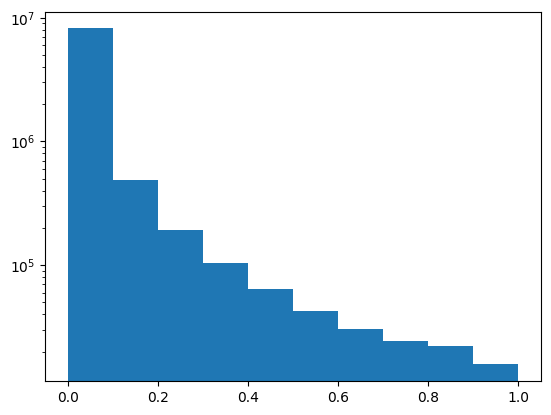

In [30]:
plt.hist(truth_galaxy_psf_df["blendedness"], log=True)
plt.show()

In [31]:
blendedness = truth_galaxy_psf_df["blendedness"].values
np.quantile(blendedness[~np.isnan(blendedness)], q=[0.01, 0.03, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

array([0.        , 0.        , 0.        , 0.        , 0.00163638,
       0.02584892, 0.10810987, 0.21474713, 0.60275362])

In [32]:
truth_galaxy_psf_df["shear_1"].describe()

count    1.156983e+07
mean    -1.852040e-03
std      1.308601e-02
min     -1.186248e-01
25%     -8.045422e-03
50%     -1.206914e-03
75%      4.239111e-03
max      1.379704e-01
Name: shear_1, dtype: float64

In [33]:
truth_galaxy_psf_df["shear_2"].describe()

count    1.156983e+07
mean     8.723785e-04
std      1.310692e-02
min     -1.288191e-01
25%     -5.089510e-03
50%      5.599827e-04
75%      6.920214e-03
max      1.326483e-01
Name: shear_2, dtype: float64

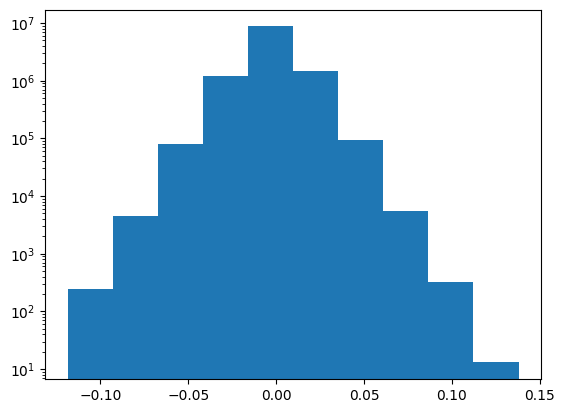

In [34]:
plt.hist(truth_galaxy_psf_df["shear_1"], log=True)
plt.show()

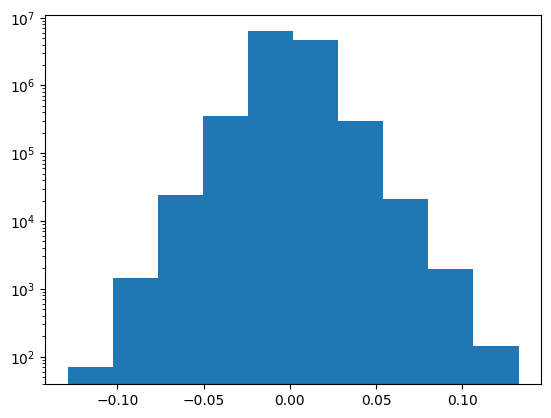

In [35]:
plt.hist(truth_galaxy_psf_df["shear_2"], log=True)
plt.show()

In [36]:
truth_galaxy_psf_df["ellipticity_1_true"].describe()

count    1.156983e+07
mean     3.355728e-05
std      1.677745e-01
min     -9.231520e-01
25%     -5.234647e-02
50%     -6.624090e-07
75%      5.239807e-02
max      9.283547e-01
Name: ellipticity_1_true, dtype: float64

In [37]:
truth_galaxy_psf_df["ellipticity_2_true"].describe()

count    1.156983e+07
mean    -5.228774e-05
std      1.678313e-01
min     -9.273545e-01
25%     -5.247077e-02
50%     -6.802741e-06
75%      5.232371e-02
max      9.300864e-01
Name: ellipticity_2_true, dtype: float64

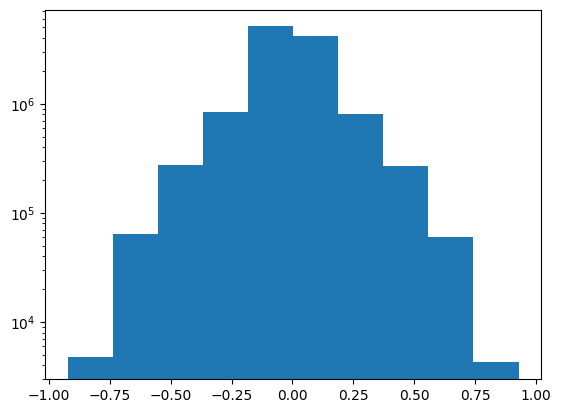

In [38]:
plt.hist(truth_galaxy_psf_df["ellipticity_1_true"], log=True)
plt.show()

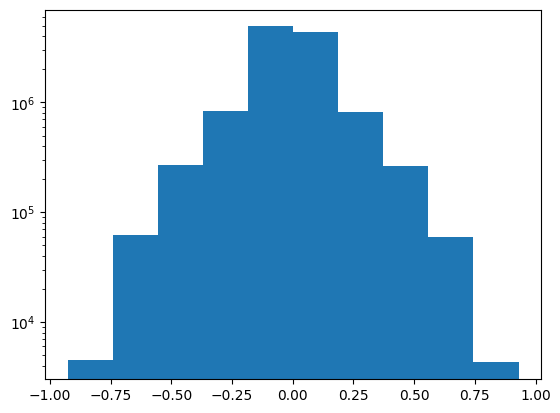

In [39]:
plt.hist(truth_galaxy_psf_df["ellipticity_2_true"], log=True)
plt.show()

### Save to File

In [40]:
# # create a pickle file 
truth_galaxy_psf_df.to_pickle(output_dir / f"merged_catalog_with_flux_over_{flux_min}.pkl")